# 전이학습 
- 고양이 강아지 인식 모델의 성능을 개선하기 위해서 전이학습을 사용 (GPU 사용 권장)
- [전이학습 개념](https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras)
- Xception 모델을 사용한다
 - 이미지 크기로 (299, 299)를 사용한다
 - 이미지넷으로 사전 훈련된 네트워크를 사용
 - 1000개의 객체를 구분하는 모델이나, 여기서는 고양이, 강아지 이진 분류에 사용  

- 1) 분류기만 재학습시키는 방법
  - 특성 추출부분 즉, 합성곱 필터링 영역(convolutional base)은 그대로 사용
  - 분류기(전결합망) 부분의 파라미터만 고양이/강아지 데이터로 학습시킨다
- 2) 미세 조정 방식
  - 합성곱 필터링 영역의 일부 (상단)을 미세조정(fine tuning) 시키는 방법
  - [기구축된 모델](https://keras.io/api/applications/)

# import

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import os, os.path, shutil
import zipfile
import matplotlib.image as mpimg
import tensorflow as tf
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception

from keras import layers
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
from tensorflow.keras import optimizers

# 데이터

In [2]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 65.4M    0 64363    0     0   119k      0  0:09:21 --:--:--  0:09:21  119k
  2 65.4M    2 1950k    0     0  1312k      0  0:00:51  0:00:01  0:00:50 1314k
 19 65.4M   19 12.8M    0     0  5276k      0  0:00:12  0:00:02  0:00:10 5281k
 36 65.4M   36 23.9M    0     0  7046k      0  0:00:09  0:00:03  0:00:06 7049k
 53 65.4M   53 34.9M    0     0  7977k      0  0:00:08  0:00:04  0:00:04 7981k
 69 65.4M   69 45.7M    0     0  8546k      0  0:00:07  0:00:05  0:00:02 9441k
 87 65.4M   87 56.9M    0     0  8993k      0  0:00:07  0:00:06  0:00:01 11.0M
100 65.4M  100 65.4M    0     0  9237k      0  0:00:07  0:00:07 --:--:-- 11.0M


In [3]:
# 압축 풀기
with zipfile.ZipFile("cats_and_dogs_filtered.zip", 'r') as z: 
    print(z.namelist()) 
    z.extractall() 

['cats_and_dogs_filtered/', 'cats_and_dogs_filtered/vectorize.py', 'cats_and_dogs_filtered/validation/', 'cats_and_dogs_filtered/train/', 'cats_and_dogs_filtered/validation/dogs/', 'cats_and_dogs_filtered/validation/dogs/dog.2127.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2126.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2125.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2124.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2123.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2122.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2121.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2120.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2119.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2118.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2117.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2116.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2115.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2114.jpg', 'cats_and_dogs_filtered/validation/dogs/dog.2113.

In [4]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_dir

'./cats_and_dogs_filtered\\train'

# 1) 분류기만 재학습시키는 방법
 - 합성곱 필터링 영역(convolutional base)은 그대로 사용
 - 분류기(전결합망) 부분은 고양이/강아지 데이터로 재학습시킨다

## 모델 가져오기

-  Xception() 생성자를 호출하면 사전학습된 모델을 가져온다
- input_shape의 크기를 (299, 299)로 설정한다
- weights = 'imagenet'는 이미지넷으로 학습된 파라미터를 사용하겠다는 것을 지정
- include_top은 기존의 1000개 전결합망 분류기를 포함할지를 선택 (여기서는 필요없다)

In [11]:
image_size = 299
conv_base = Xception(weights = 'imagenet',
                 include_top=False,
                 input_shape=(image_size, image_size, 3))

conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 19, 19, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, 19, 19, 728)          2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_19 (Add)                (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_18[0][0]']              
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_19[0][0]']              
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 19, 19, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_22 (A

## 모델 정의

In [12]:
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax')) 

## 학습을 동결하지 않으면 모두 재 학습된다!

In [13]:
conv_base.trainable = False

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               26214528  
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 47076266 (179.58 MB)
Trainable params: 26214786 (100.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [15]:
# 데이터 증식

train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True,
  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(image_size,image_size),
											   classes=['cats','dogs'],
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(image_size,image_size),
											   classes=['cats','dogs'],
											   batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

history = model.fit_generator(
    generator=train_generator, 
    epochs=30,
    callbacks=callbacks_list,
    validation_data=validation_generator)

C:\Users\User\AppData\Local\Temp\ipykernel_23400\3444879164.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 [==============================] - 505s 5s/step - loss: 2.4496 - accuracy: 0.9430 - val_loss: 0.3862 - val_accuracy: 0.9900
Epoch 2/30
100/100 [==============================] - 482s 5s/step - loss: 0.7285 - accuracy: 0.9765 - val_loss: 0.1261 - val_accuracy: 0.9900
Epoch 3/30
100/100 [==============================] - 476s 5s/step - loss: 0.4239 - accuracy: 0.9770 - val_loss: 0.2397 - val_accuracy: 0.9880
Epoch 4/30
100/100 [==============================] - 499s 5s/step - loss: 0.4058 - accuracy: 0.9795 - val_loss: 0.1687 - val_accuracy: 0.9920
Epoch 5/30
100/100 [==============================] - 490s 5s/step - loss: 0.2100 - accuracy: 0.9830 - val_loss: 0.1375 - val_accuracy: 0.9930
Epoch 6/30
100/100 [==============================] - 499s 5s/step - loss: 0.3657 - accuracy: 0.9800 - val_loss: 0.0890 - val_accuracy: 0.9930
Epoch 7/30
100/100 [==============================] - 512s 5s/step - loss: 0.1700 - accuracy: 0.9860 - val_loss: 0.0695 - val_accuracy: 0.9960

## 성능 확인

In [17]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

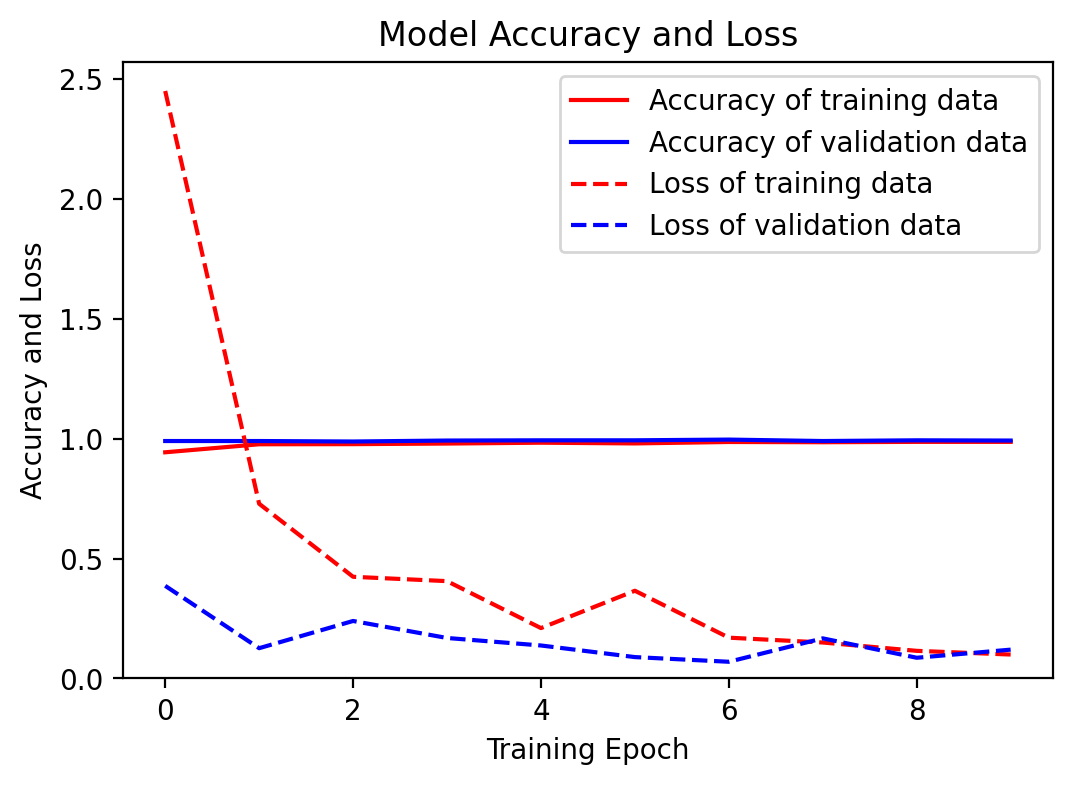

In [18]:
show_4_graphs(history)

## 2) 미세조정 방법
- 상위 계층 일부를 재학습시킨다
- 미세조정은 앞에서 소개한 절차, 즉, 분류기인 전결합망 부분을 먼저 학습시킨 후에 수행해야 한다 (분류기 학습과 미세조정을 동시에 수행하면 성능이 떨어진다)

In [19]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 19, 19, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, 19, 19, 728)          2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_19 (Add)                (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_18[0][0]']              
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_19[0][0]']              
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 19, 19, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_22 (A

### 상위의 일부 블록만 미세조정 하겠다 (동결을 풀어야 한다)

In [20]:
# 일단 모든 동결을 푼다
conv_base.trainable = True

# Xception에서는 block14_sepconv1 이후의 블록을 풀겠다
# 아래 if 문에서 처리

FLAG = False
for layer in conv_base.layers:

  if layer.name == 'block14_sepconv1':
    FLAG = True
  if FLAG:
    layer.trainable = True
  else:
    layer.trainable = False

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

history = model.fit_generator(
    generator=train_generator, 
    epochs=30,
    callbacks=callbacks_list,
    validation_data=validation_generator)

C:\Users\User\AppData\Local\Temp\ipykernel_23400\3444879164.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 [==============================] - 506s 5s/step - loss: 0.2402 - accuracy: 0.9715 - val_loss: 0.0495 - val_accuracy: 0.9890
Epoch 2/30
100/100 [==============================] - 506s 5s/step - loss: 0.0465 - accuracy: 0.9855 - val_loss: 0.0469 - val_accuracy: 0.9940
Epoch 3/30
100/100 [==============================] - 518s 5s/step - loss: 0.0662 - accuracy: 0.9845 - val_loss: 0.0164 - val_accuracy: 0.9930
Epoch 4/30
100/100 [==============================] - 496s 5s/step - loss: 0.0376 - accuracy: 0.9910 - val_loss: 0.0203 - val_accuracy: 0.9950
Epoch 5/30
100/100 [==============================] - 491s 5s/step - loss: 0.0568 - accuracy: 0.9890 - val_loss: 0.0114 - val_accuracy: 0.9980
Epoch 6/30
100/100 [==============================] - 474s 5s/step - loss: 0.0267 - accuracy: 0.9915 - val_loss: 0.0440 - val_accuracy: 0.9960
Epoch 7/30
100/100 [==============================] - 476s 5s/step - loss: 0.0247 - accuracy: 0.9960 - val_loss: 0.0530 - val_accuracy: 0.9980

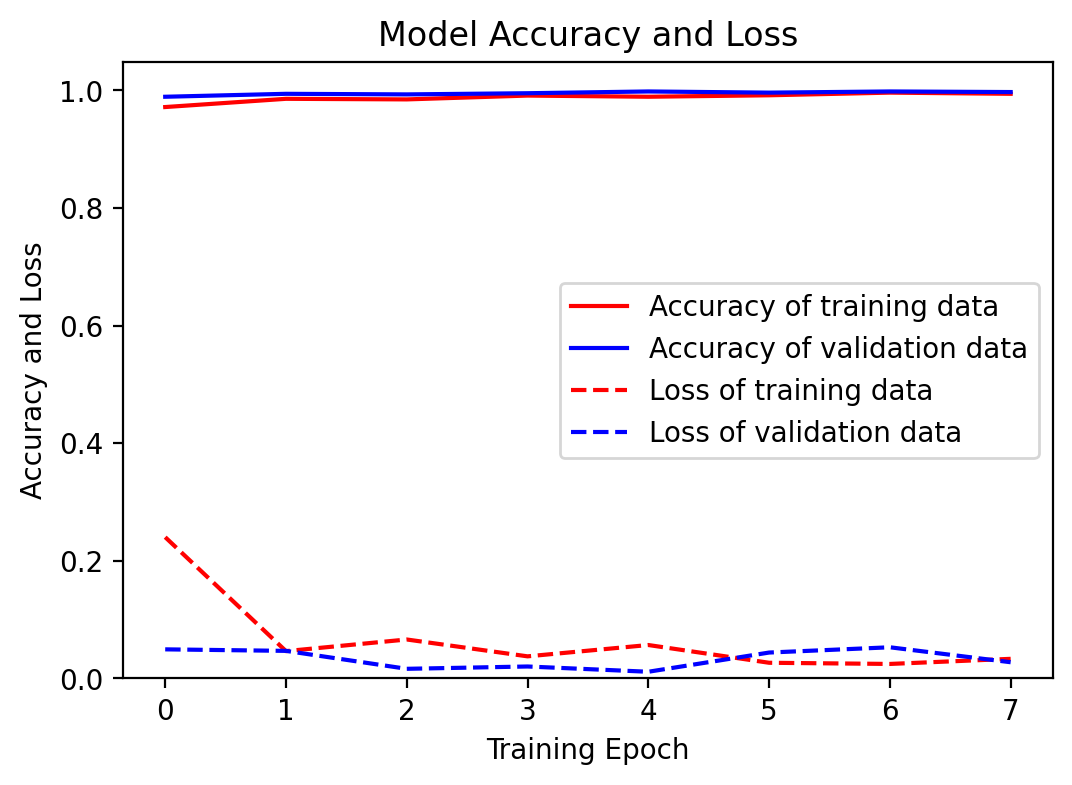

In [22]:
show_4_graphs(history)

- 성능이 더 개선되었다.


# 모델 사용하기 

## 강아지 사진 검증
- 강아지 사진 500 장에 대한 검증과 오분류된 사진 보기

### 이미지 전처리 함수

In [23]:
def process_images(folder, size):
  images = []
  processed_images = []
  
  files = os.listdir(folder)
  
  for file in files:
    image = mpimg.imread(os.path.join(folder, file))
    if image is not None:
        rescaled = cv2.resize(image, (size, size))/255.0
        images.append(image)
        processed_images.append(rescaled)
        
  return files, images, np.array(processed_images)

In [24]:
import cv2
# 검증할 이미지가 있는 폴더
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# 먼저 강아지 이미지를 적용하겠다
folder = validation_dogs_dir

files, images, processed_images = process_images(folder, image_size)
predictions = model.predict(processed_images)

files[:5]

16/16 [==============================] - 61s 4s/step


['dog.2000.jpg',
 'dog.2001.jpg',
 'dog.2002.jpg',
 'dog.2003.jpg',
 'dog.2004.jpg']

In [25]:
processed_images.shape

(500, 299, 299, 3)

- 예측결과 보기 (고양이: 0, 강아지: 1)

In [27]:
# 강아지로 정상적으로 예측한 갯수 보기
(predictions[:,1]>0.5).sum()

497

### 오분류된 샘플 인덱스

In [28]:
wrong_index = [i for i, x in enumerate(list(predictions[:,1]>0.5)) if x == False]
print(len(wrong_index))
wrong_index[:5]

3


[264, 295, 325]

### 인데스에 해당하는 이미지 출력

In [30]:
def show_N_images(images, index_to_see, files, N_max=5):
  N = min(len(index_to_see), N_max)
  plt.figure(figsize=(12,5))
  for i in range(N):
     ix = index_to_see[i]
     plt.subplot(1, N, i + 1)
     plt.axis('off')
     plt.title(files[ix])
     plt.imshow(cv2.cvtColor(images[ix], cv2.COLOR_BGR2RGB))

- 오분류된 이미지 보기

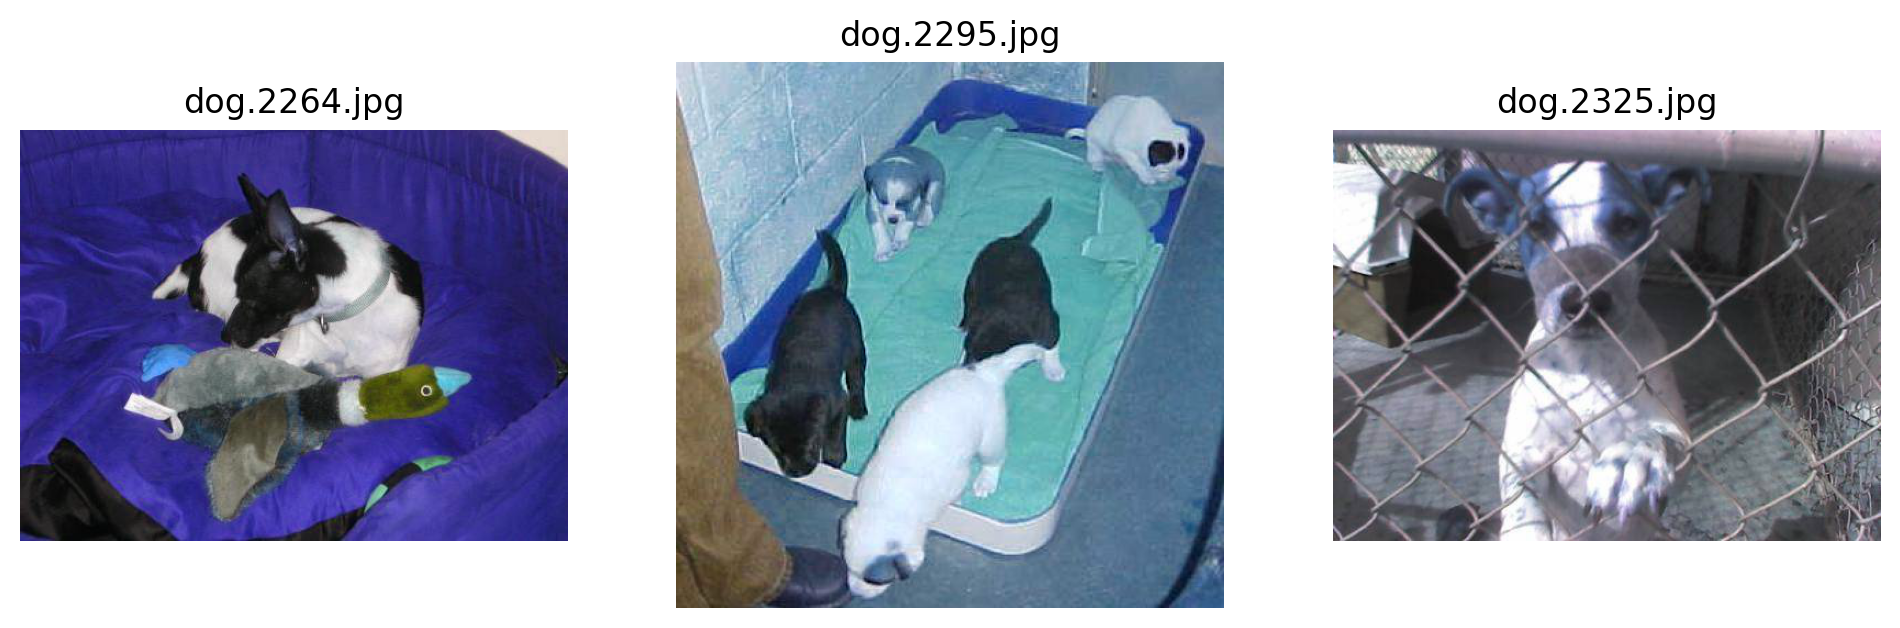

In [31]:
show_N_images(images, wrong_index, files,5)


## 고양이 사진 검증
- 고양이 사진 500 장에 대한 검증과 오분류된 사진 보기

In [32]:
# 고양이 이미지를 적용하겠다

folder = validation_cats_dir
files, images, processed_images = process_images(folder, image_size)
predictions = model.predict(processed_images)

16/16 [==============================] - 50s 3s/step


In [33]:
wrong_index = [i for i, x in enumerate(list(predictions[:,0]>0.5)) if x == False]
print(len(wrong_index))
wrong_index[:5]

1


[85]

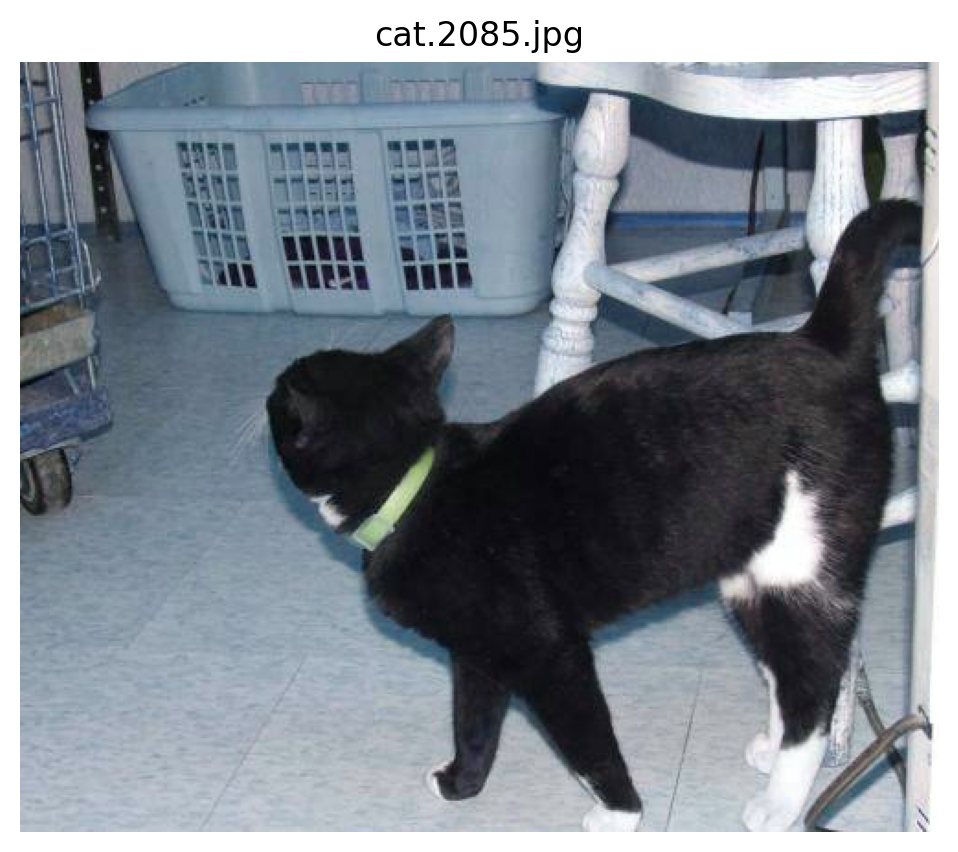

In [34]:
show_N_images(images, wrong_index, files)